### Assignment 1-2
----
COMP 7745 Machine Learning <br><br>
Univerity of Memphis <br>
Fall 2022 <br>

@author <br>
Bereket Kebede <br>

### Logistic Regression
----

https://www.kaggle.com/code/apapiu/regularized-linear-models/notebook

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

C:\Users\Berek\AppData\Local\Temp\ipykernel_16692\2916246244.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [30]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [31]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [32]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'log(price + 1)'}>]], dtype=object)

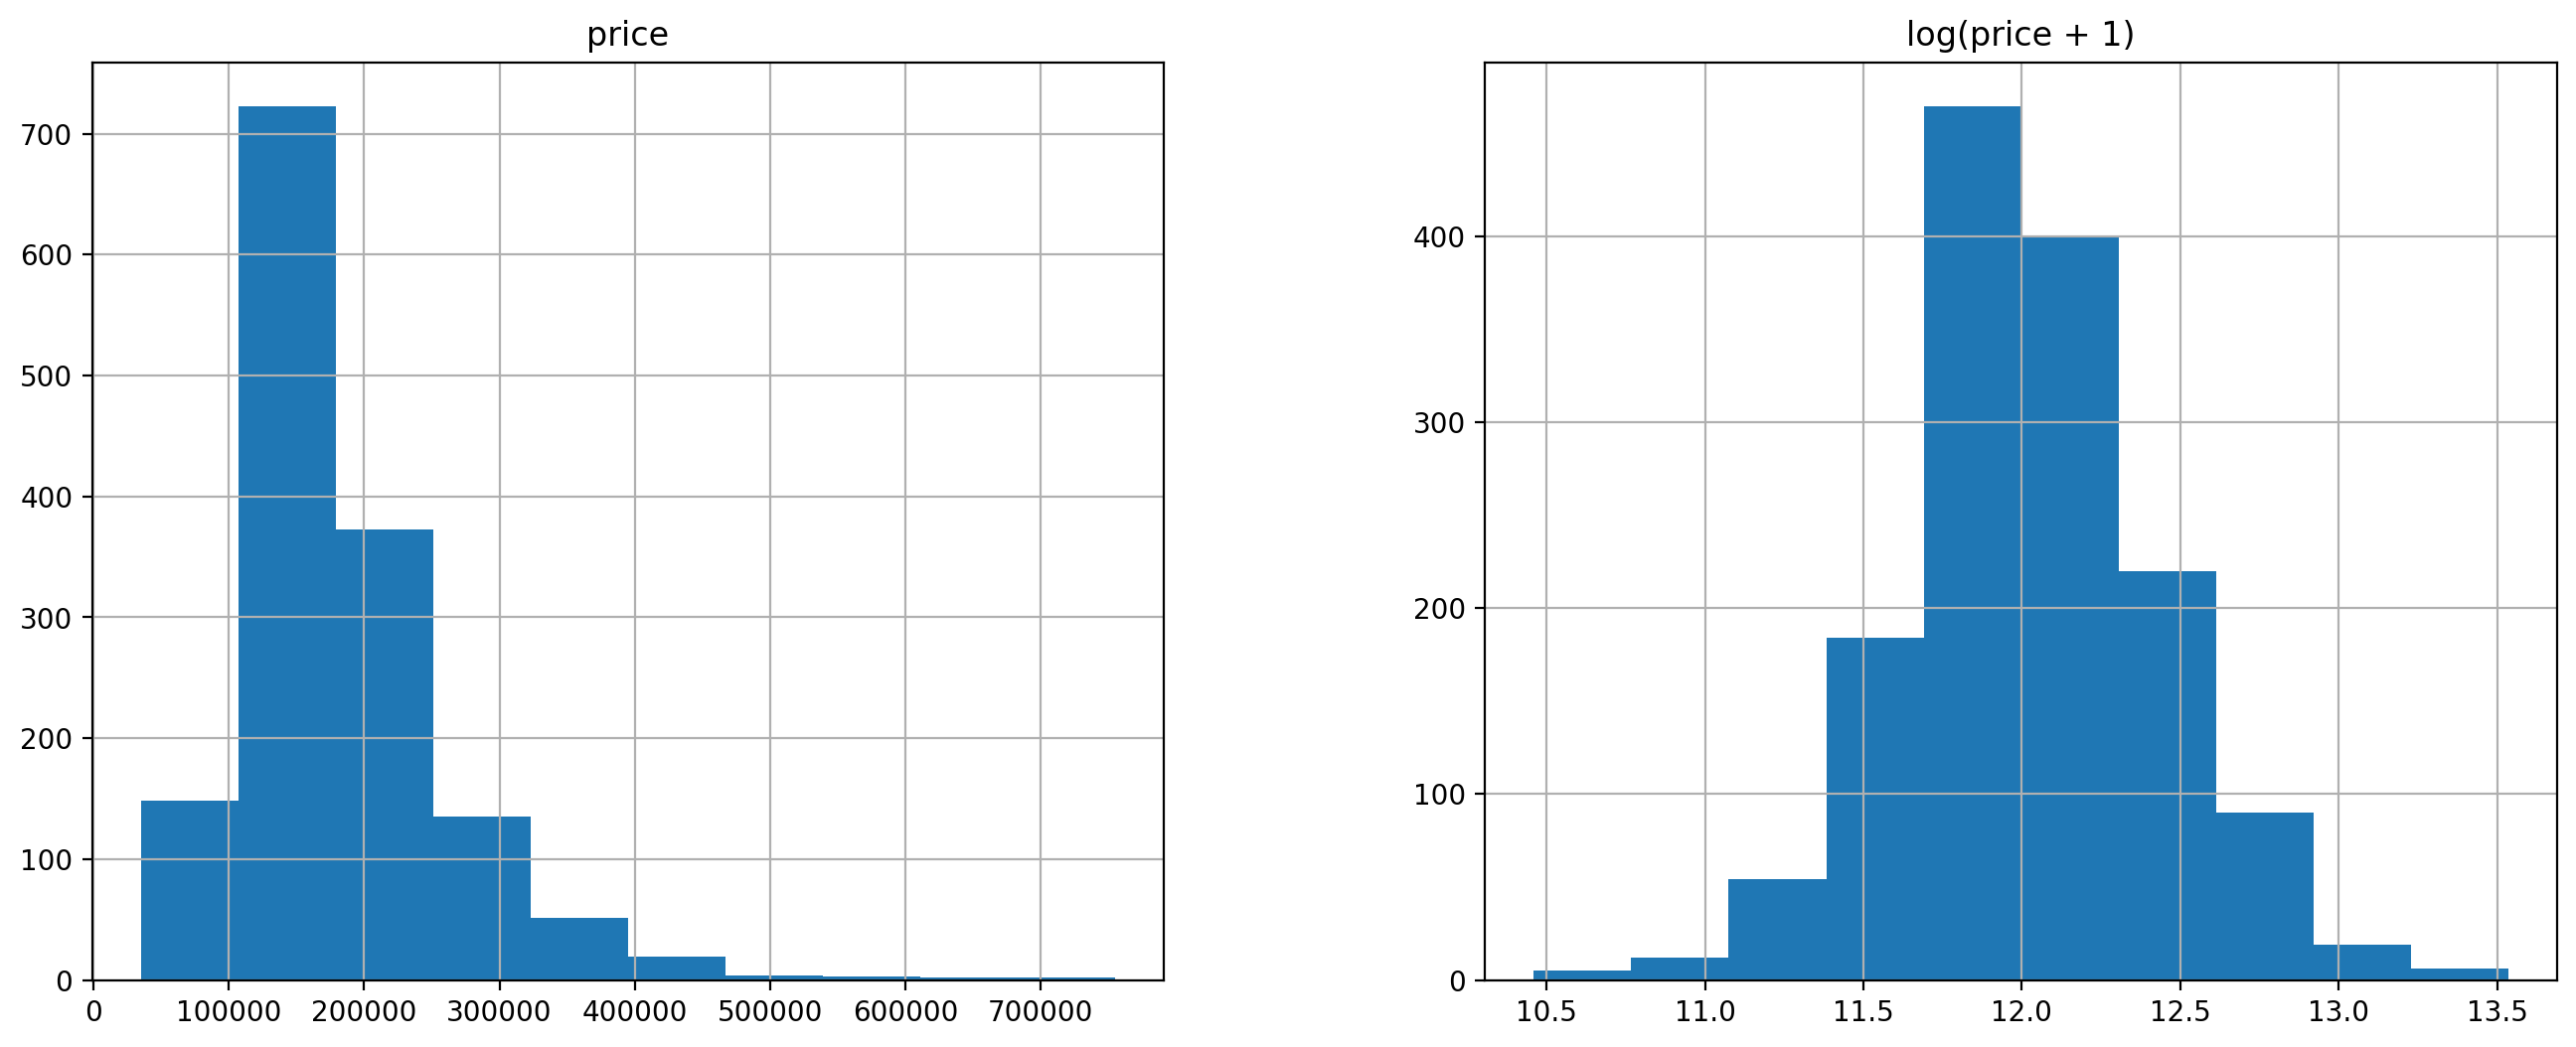

In [33]:
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [34]:
#log transform the target:

train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [35]:
all_data = pd.get_dummies(all_data)

In [36]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [38]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Models

<br>
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

### Ridge Regression
----

In [39]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [40]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [41]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

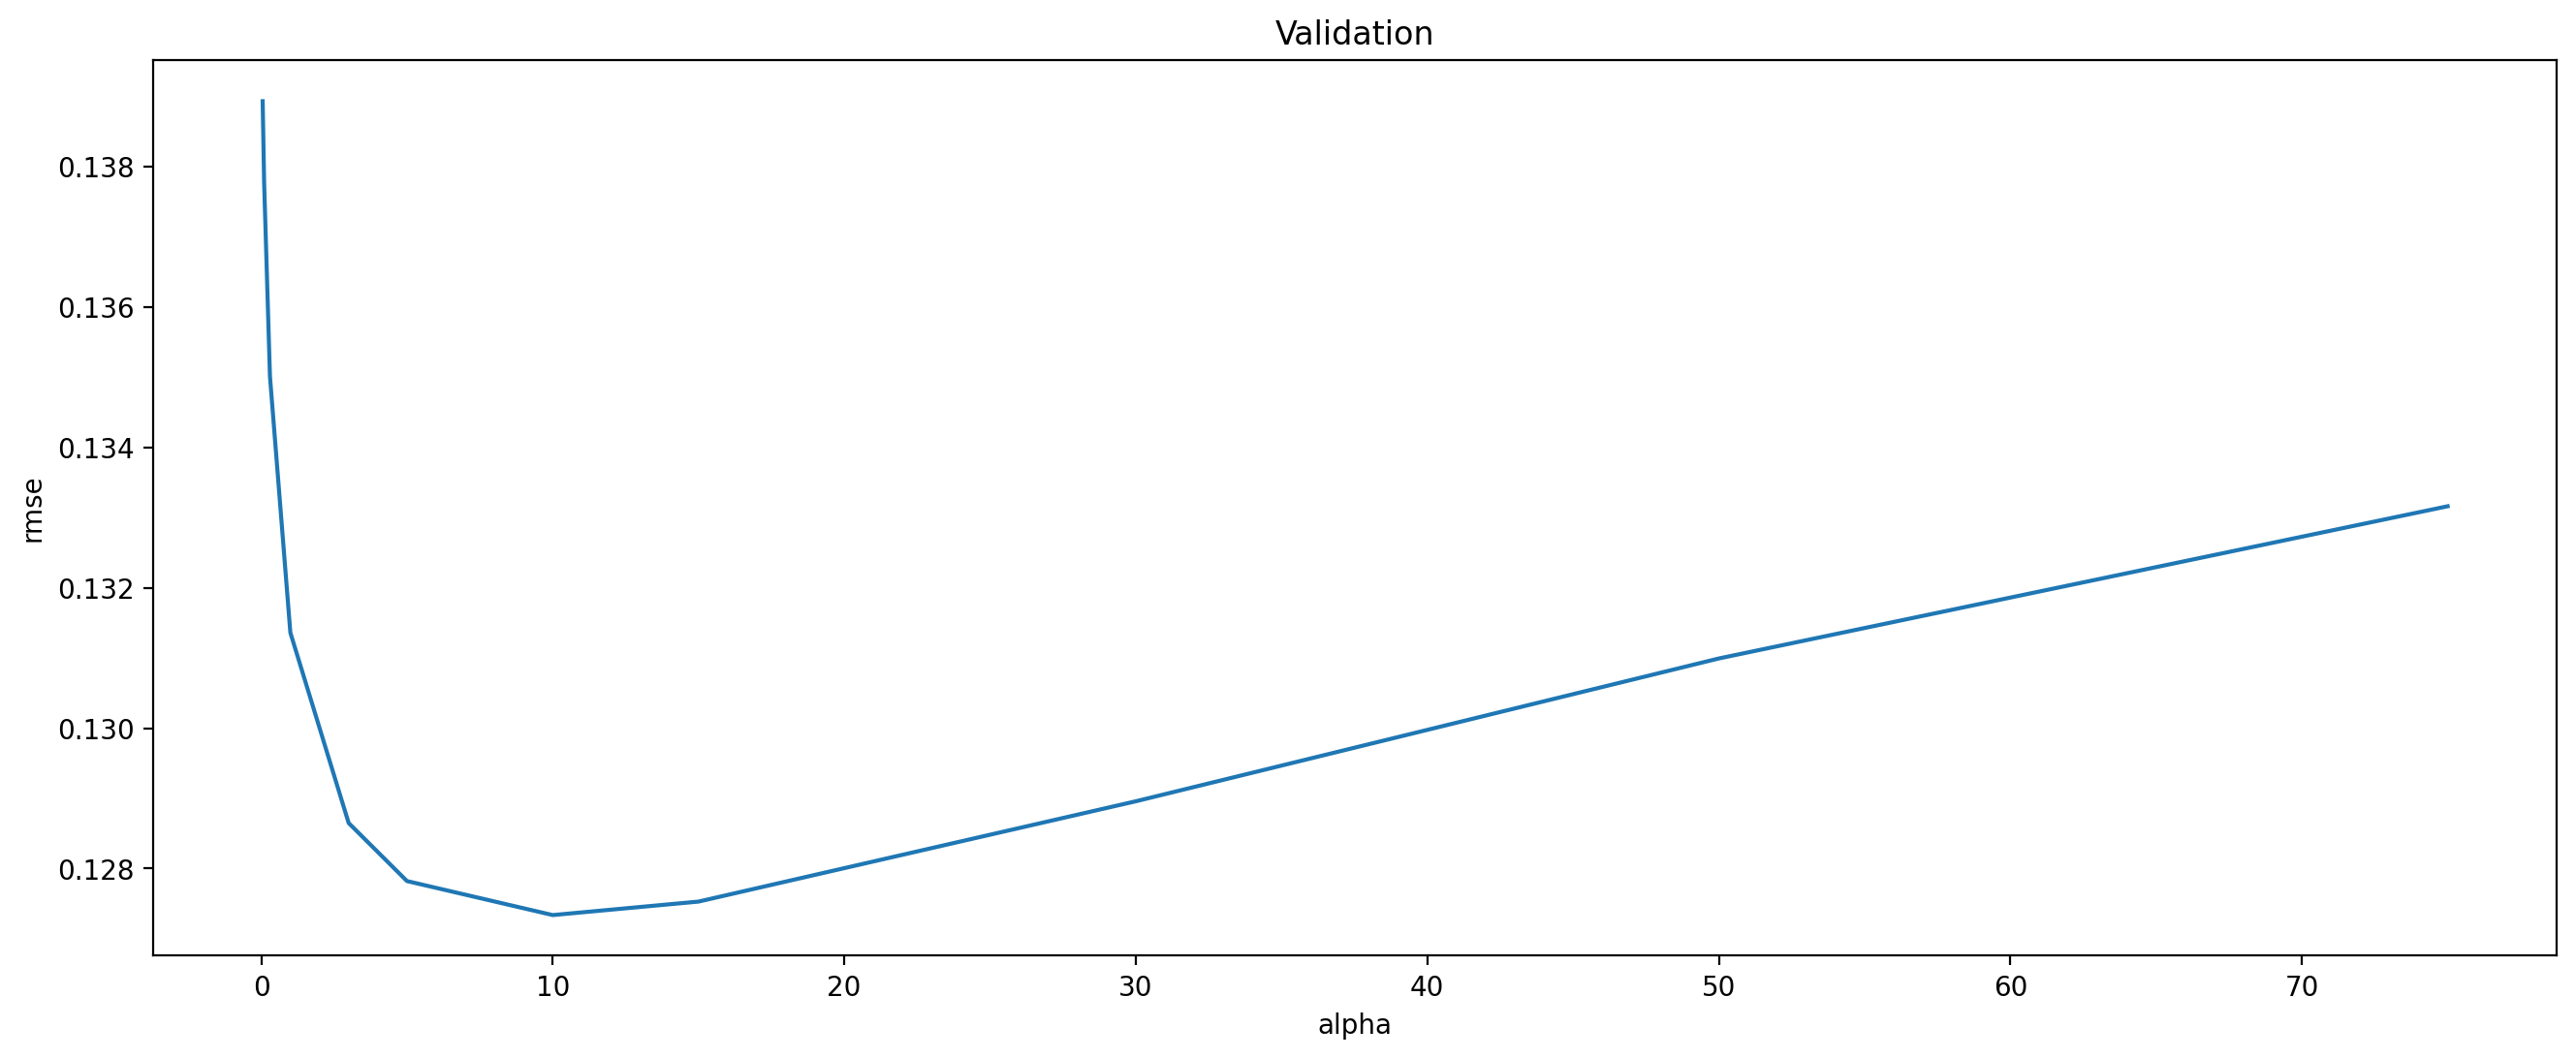

In [42]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [43]:
cv_ridge.min()

0.12733734668670757

So for the Ridge regression we get a rmse of about 0.127 <br>

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

### Lasso Regression
----


In [44]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [45]:
rmse_cv(model_lasso).mean()

0.12256735885048142

In [46]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [47]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


In [48]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

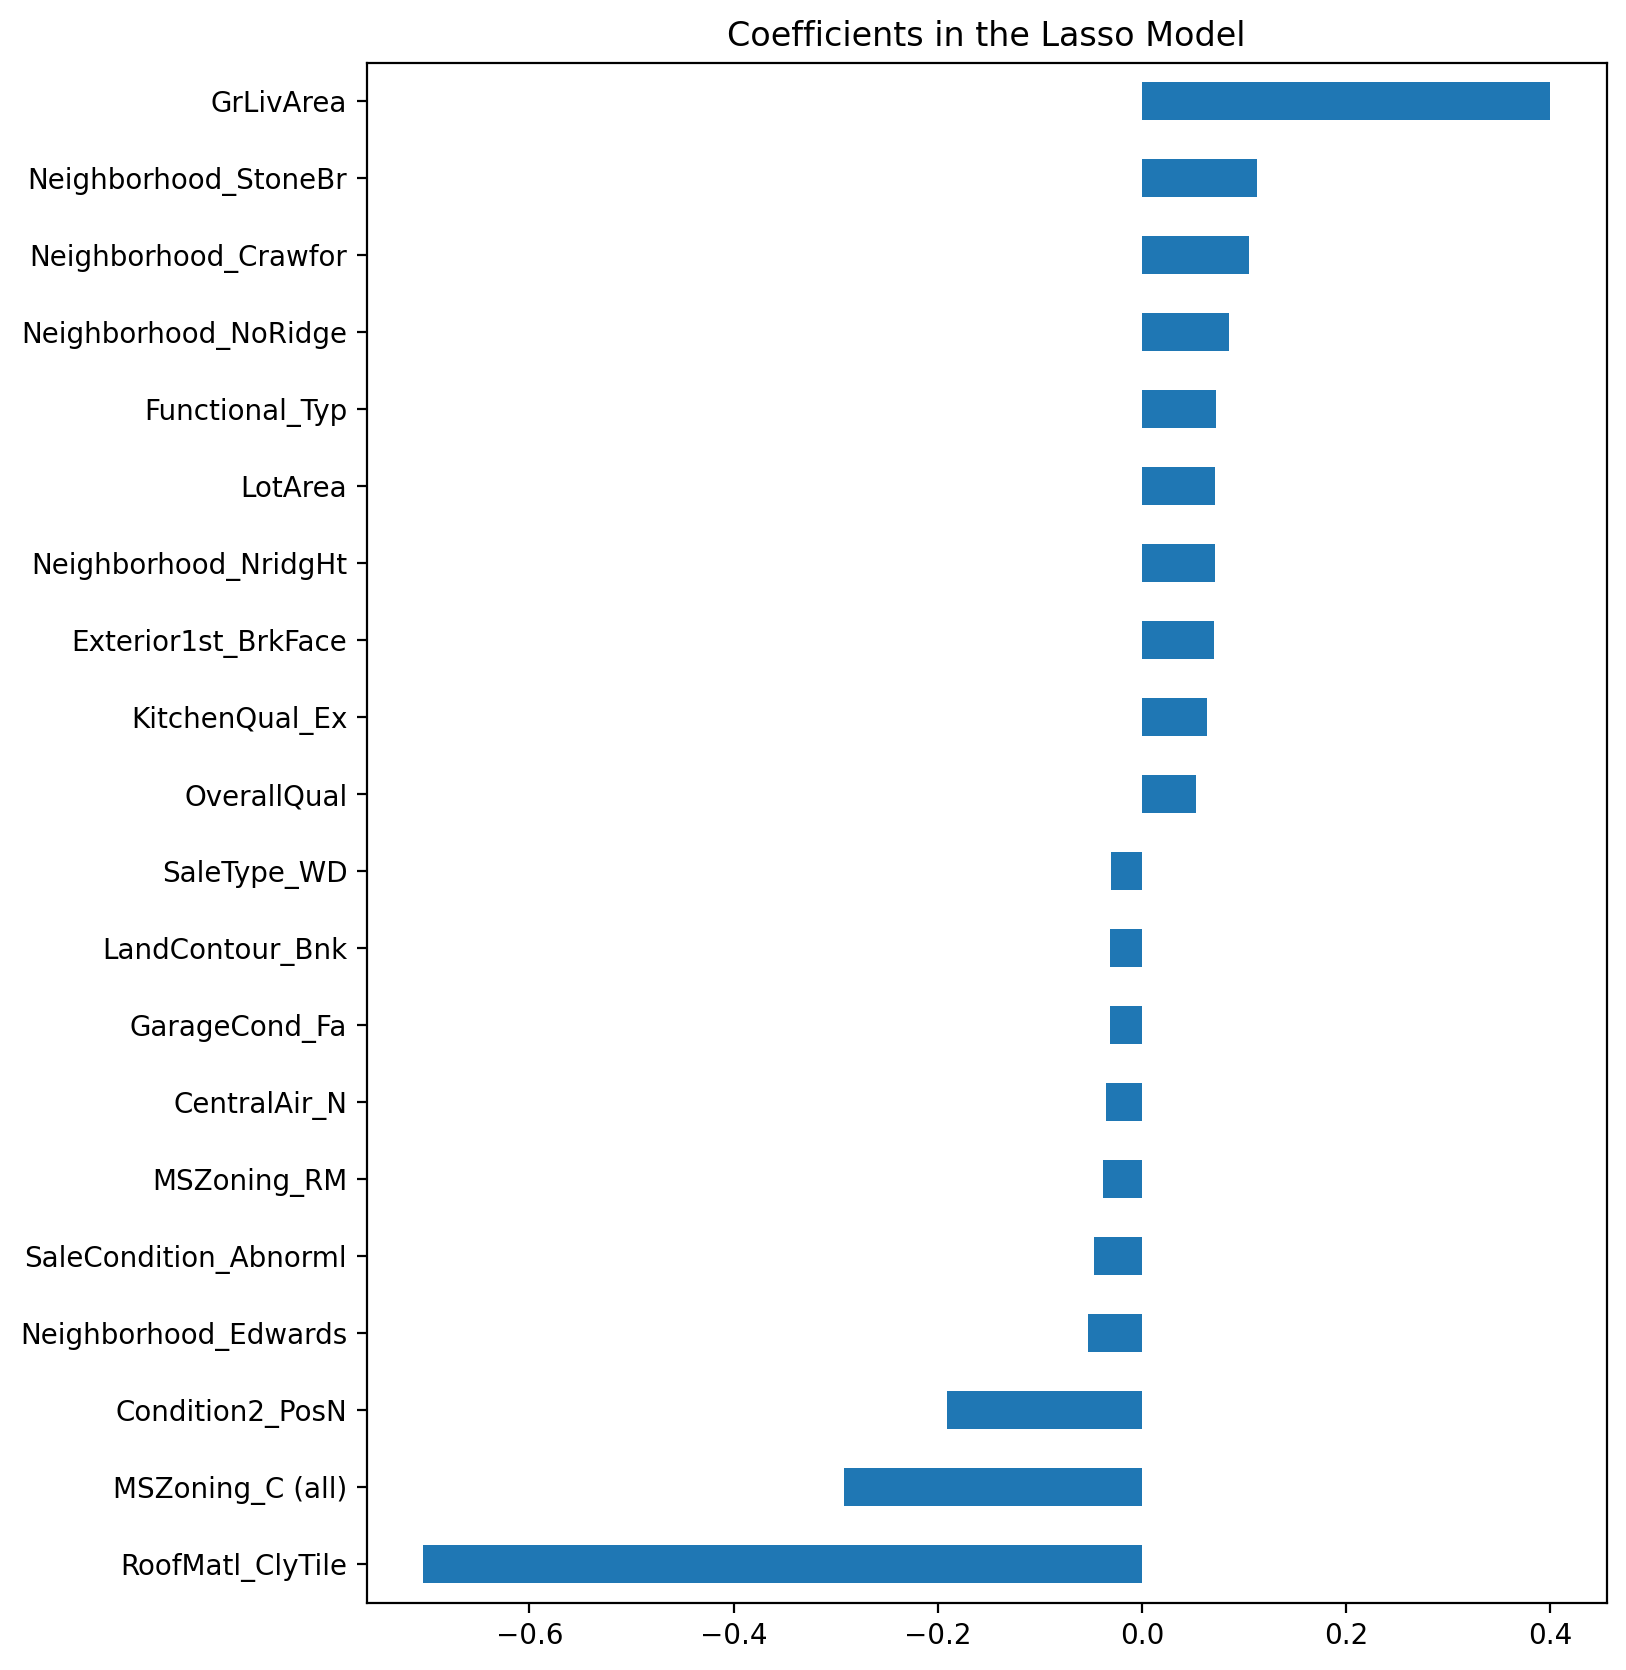

In [49]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

C:\Users\Berek\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='preds', ylabel='residuals'>

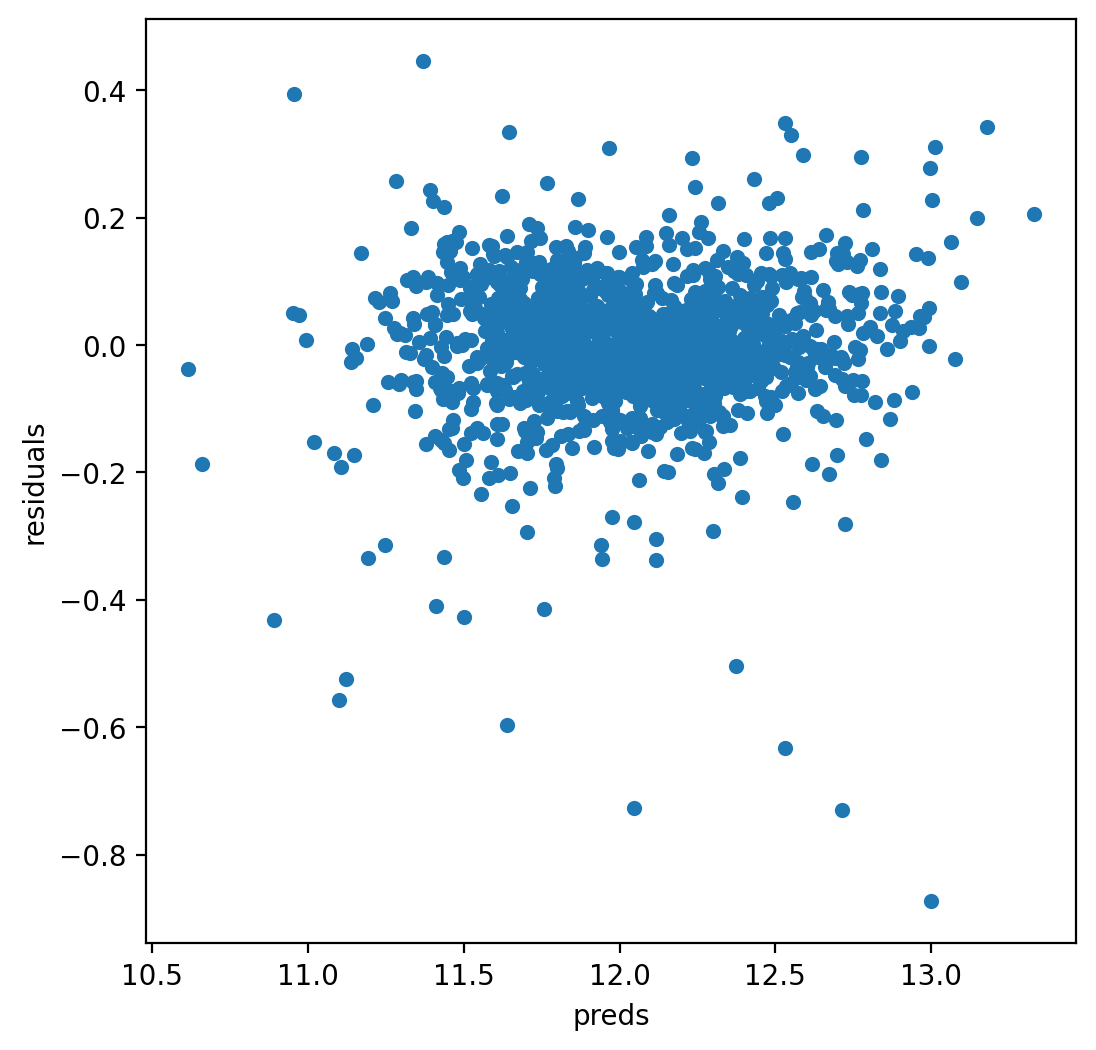

In [50]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Elastic Net
-----

In [55]:
model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y)

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42, selection='random')

In [56]:
rmse_cv(model_lasso).mean()

0.12256735885048142